In [2]:
import os 
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from progressbar import progressbar
import time
import os
import cv2
import skimage.io
import PIL

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
!pip install openslide-python
!sudo apt update && apt install -y openslide-tools

import openslide

     |████████████████████████████████| 316 kB 7.4 MB/s 
  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp37-cp37m-linux_x86_64.whl size=27715 sha256=15dd57408dbac84ace6006c66b7964f27f7920df0ed2afaa8b0c679ec968cd0e
  Stored in directory: /root/.cache/pip/wheels/6f/c3/97/980962653f9305314bfb6d93f80be5e21f13e206af66fc7ad3
Successfully built openslide-python
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8

In [4]:
! pip install -q imagecodecs #library that provides functions for use in the tifffile
! pip install -q warmup_scheduler #Gradually warm-up(increasing) learning rate for pytorch's optimizer
! pip install -q efficientnet_pytorch

     |████████████████████████████████| 31.0 MB 1.3 MB/s 


In [5]:
# Deep learning model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [6]:
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
matplotlib.rcParams['figure.figsize'] = (8,7)

In [7]:
DATASET_DIR = '/content/gdrive/MyDrive/ColabNotebooks/DLMI/Kaggle_Challenge/'
TRAIN_DIR = os.path.join(DATASET_DIR, 'train/train/')
TEST_DIR = os.path.join(DATASET_DIR, 'test/test/')
MASKS_DIR = os.path.join(DATASET_DIR, 'train_label_masks/train_label_masks/')

In [8]:
train = pd.read_csv(DATASET_DIR+'train.csv')
test = pd.read_csv(DATASET_DIR+'test.csv')

# Train set

In [9]:
train.head(10)

,image_id,data_provider,isup_grade,gleason_score
0,995df9b93db1e396b57692c6c7f1d673,radboud,0,negative
1,86d4621be3deca4f8d461e3abce7d585,radboud,4,4+4
2,e2578d331ae6cb3bc649027498c8ff8d,radboud,1,3+3
3,c65fcde885b4f231d03cefb0fc75f4fa,radboud,4,4+4
4,c4bbe05f5d77f1a42bc95191285ab1bb,radboud,3,4+3
5,409d6815cecdf483be748a75c63c0b2e,radboud,1,3+3
6,9b8895fcc7325a09cc4ff4653fbb48f9,karolinska,2,3+4
7,20b4e3b00b34fb10d8e00ab145d70692,karolinska,5,5+4
8,16cc34b16c0b30e43e8c33f572440ae6,radboud,2,3+4
9,414b65b71e83147e249552f1bd31decb,karolinska,0,0+0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       340 non-null    object
 1   data_provider  340 non-null    object
 2   isup_grade     340 non-null    int64 
 3   gleason_score  340 non-null    object
dtypes: int64(1), object(3)
memory usage: 10.8+ KB


In [11]:
print("unique ids : ", len(train.image_id.unique()))
print("unique data provider : ", len(train.data_provider.unique()))
print("unique isup_grade(target) : ", len(train.isup_grade.unique()))
print("unique gleason_score : ", len(train.gleason_score.unique()))

unique ids :  340
unique data provider :  2
unique isup_grade(target) :  6
unique gleason_score :  11


In [12]:
filenames = [f.split('.tiff')[0] for f in os.listdir(TRAIN_DIR) if f.endswith('.tiff')]
train.loc[train.image_id == filenames[0]]

,image_id,data_provider,isup_grade,gleason_score
68,01065a75c0dfd95f78893ebbfd3c70b3,karolinska,2,3+4


**The mask values depend on the data provider:**

1.   Karolinska (Swedish university) : Regions are labelled.

> Valid values are: 
- 0: background (non tissue) or unknown
- 1: benign tissue (stroma and epithelium combined)
- 2: cancerous tissue (stroma and epithelium combined)


2.   Radboud (Dutch university) : Prostate glands are individually labelled.

> Valid values are: 
- 0: background (non tissue) or unknown
- 1: stroma (connective tissue, non-epithelium tissue)
- 2: healthy (benign) epithelium
- 3: cancerous epithelium (Gleason 3)
- 4: cancerous epithelium (Gleason 4)
- 5: cancerous epithelium (Gleason 5)

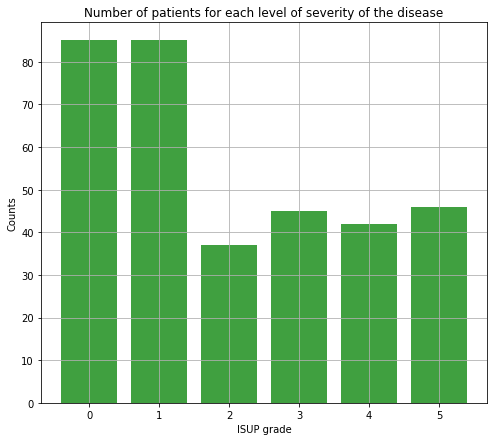

In [14]:
index = train.isup_grade.value_counts().index.tolist()
values = train.isup_grade.value_counts().values.tolist()

plt.bar(index, values, facecolor='g', alpha=0.75)

plt.xlabel('ISUP grade')
plt.ylabel('Counts')
plt.title('Number of patients for each level of severity of the disease')
# Rotation of the bar names
plt.xticks(index, rotation=0)
# plt.subplot_adjust(bottom=0.01, top=0.99)

plt.grid(True)
plt.show()

In [15]:
train.gleason_score.value_counts()

3+3         85
0+0         68
4+3         45
4+4         37
3+4         37
4+5         37
negative    17
5+4          7
3+5          3
5+3          2
5+5          2
Name: gleason_score, dtype: int64

In [16]:
m = train.gleason_score=='0+0'
train.gleason_score = train.gleason_score.mask(m, 'negative')

train.gleason_score.value_counts()

negative    85
3+3         85
4+3         45
4+4         37
3+4         37
4+5         37
5+4          7
3+5          3
5+3          2
5+5          2
Name: gleason_score, dtype: int64

In [17]:
print(train[(train['gleason_score']=='3+4') | (train['gleason_score']=='4+3')]['isup_grade'].unique())
print(train[(train['gleason_score']=='3+5') | (train['gleason_score']=='5+3')]['isup_grade'].unique())
print(train[(train['gleason_score']=='5+4') | (train['gleason_score']=='4+5')]['isup_grade'].unique())

[3 2]
[4]
[5]


In [18]:
print(train[train['gleason_score']=='3+4']['isup_grade'].unique())
print(train[train['gleason_score']=='4+3']['isup_grade'].unique())

[2]
[3]


In [19]:
assert (train[train.gleason_score=='3+3'].isup_grade == 1).all()
assert (train[train.gleason_score=='3+4'].isup_grade == 2).all()
assert (train[train.gleason_score=='4+3'].isup_grade == 3).all()
assert (train[train.gleason_score=='4+4'].isup_grade == 4).all()
assert (train[train.gleason_score=='3+5'].isup_grade == 4).all()
assert (train[train.gleason_score=='5+3'].isup_grade == 4).all()
assert (train[train.gleason_score=='4+5'].isup_grade == 5).all()
assert (train[train.gleason_score=='5+4'].isup_grade == 5).all()
assert (train[train.gleason_score=='5+5'].isup_grade == 5).all()

assert (train[train.isup_grade==0].gleason_score =='negative').all()

In [20]:
train.data_provider.value_counts()

karolinska    194
radboud       146
Name: data_provider, dtype: int64

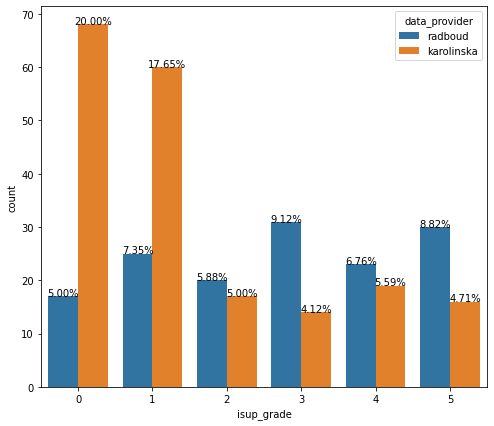

In [21]:
fig = plt.figure()
ax = sns.countplot(x="isup_grade", hue="data_provider", data=train)
for p in ax.patches:
    '''
    Courtesy of Rohit Singh for teaching me this
    https://www.kaggle.com/rohitsingh9990/panda-eda-better-visualization-simple-baseline
    '''
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
                height,
                '{:1.2f}%'.format(100*height/len(train)),
                ha="center")

(25856, 16384)
3
((25856, 16384), (6464, 4096), (1616, 1024))


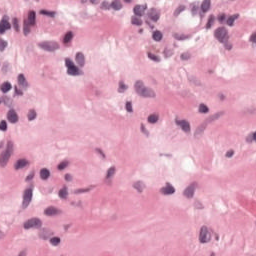

In [22]:
'''
Example for using Openslide to display an image
'''
# Open the image (does not yet read the image into memory)
example = openslide.OpenSlide(os.path.join(TRAIN_DIR, f'{filenames[1]}.tiff'))
print(example.dimensions)
print(example.level_count)
print(example.level_dimensions)

# Read a specific region of the image starting at some random coordinates (x=12500, y=13000) on level 0 and extracting a 256*256 pixel patch.
# At this point image data is read from the file and loaded into memory.
patch = example.read_region((12500,13000), 0, (256, 256))

# Display the image
display(patch)

# Close the opened slide after use
example.close()


In [23]:
train2 = train.set_index('image_id')
train2.head()

,data_provider,isup_grade,gleason_score
image_id,,,
995df9b93db1e396b57692c6c7f1d673,radboud,0,negative
86d4621be3deca4f8d461e3abce7d585,radboud,4,4+4
e2578d331ae6cb3bc649027498c8ff8d,radboud,1,3+3
c65fcde885b4f231d03cefb0fc75f4fa,radboud,4,4+4
c4bbe05f5d77f1a42bc95191285ab1bb,radboud,3,4+3


File id: OpenSlide('/content/gdrive/MyDrive/ColabNotebooks/DLMI/Kaggle_Challenge/train/train/02577ddcd838f2559936453b6071dc17.tiff')
Dimensions: (25856, 16384)
Microns per pixel / pixel spacing: 0.486
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((25856, 16384), (6464, 4096), (1616, 1024))


ISUP grade: 0
Gleason score: negative


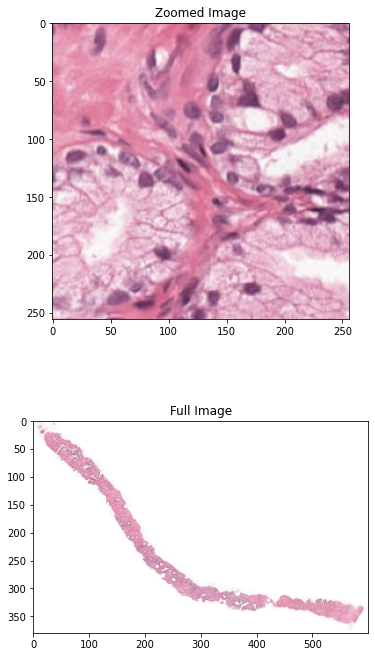

In [24]:
slide = openslide.OpenSlide(os.path.join(TRAIN_DIR, f'{filenames[1]}.tiff'))

# Here we compute the "pixel spacing": the physical size of a pixel in the image.
# OpenSlide gives the resolution in centimeters so we convert this to microns.
f,ax =  plt.subplots(2 ,figsize=(6,12))
spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
patch = slide.read_region((1780,1950), 0, (256, 256)) #ZOOMED FIGURE
ax[0].imshow(patch) 
ax[0].set_title('Zoomed Image')

max_size=(600,400)
ax[1].imshow(slide.get_thumbnail(size=max_size)) #UNZOOMED FIGURE
ax[1].set_title('Full Image')


print(f"File id: {slide}")
print(f"Dimensions: {slide.dimensions}")
print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
print(f"Number of levels in the image: {slide.level_count}")
print(f"Downsample factor per level: {slide.level_downsamples}")
print(f"Dimensions of levels: {slide.level_dimensions}\n\n")

print(f"ISUP grade: {train2.loc[filenames[1], 'isup_grade']}")
print(f"Gleason score: {train2.loc[filenames[1], 'gleason_score']}")

In [25]:
def mask_img(i,max_size=(600,400)):
  slide = openslide.OpenSlide(os.path.join(TRAIN_DIR, f'{filenames[i]}.tiff'))
  mask =  openslide.OpenSlide(os.path.join(MASKS_DIR, f'{filenames[i]}.tiff'))
  # Here we compute the "pixel spacing": the physical size of a pixel in the image.
  # OpenSlide gives the resolution in centimeters so we convert this to microns.
  f,ax =  plt.subplots(1,2 ,figsize=(18,22))
  spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
  img = slide.get_thumbnail(size=max_size) #IMAGE 

  mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
  cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

  ax[0].imshow(img) 
  #ax[0].set_title('Image')


  ax[1].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) #IMAGE MASKS
  #ax[1].set_title('Image_MASK')


  image_id = filenames[i]
  data_provider = train2.loc[filenames[i], 'data_provider']
  isup_grade = train2.loc[filenames[i], 'isup_grade']
  gleason_score = train2.loc[filenames[i], 'gleason_score']
  ax[0].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score} IMAGE")
  ax[1].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score} IMAGE_MASK")

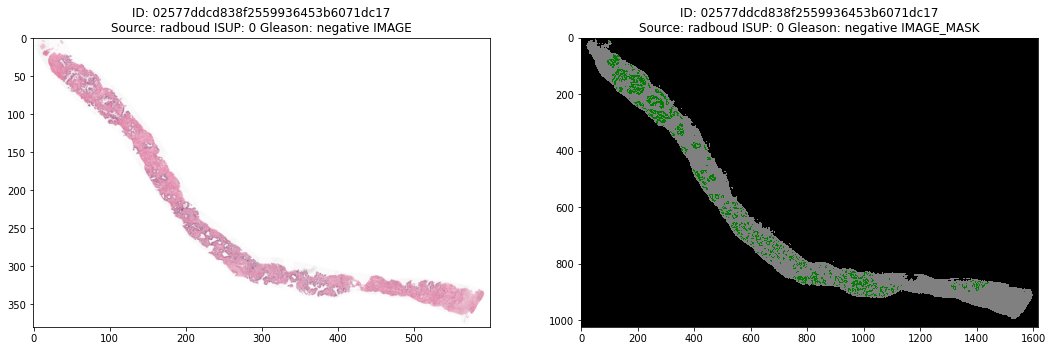

In [26]:
mask_img(1)

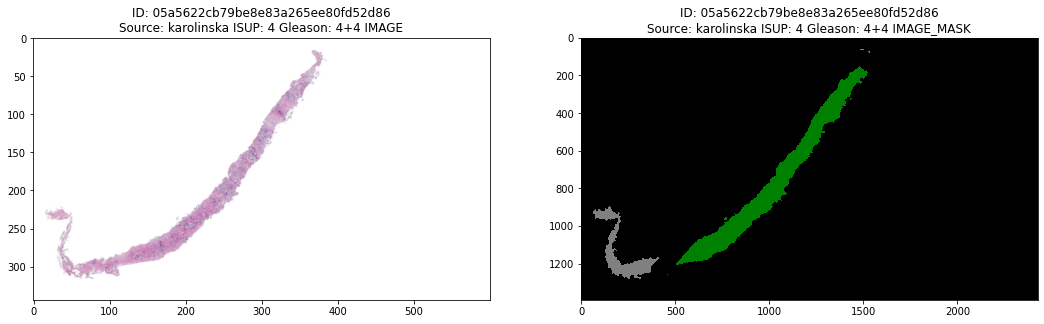

In [27]:
mask_img(2)

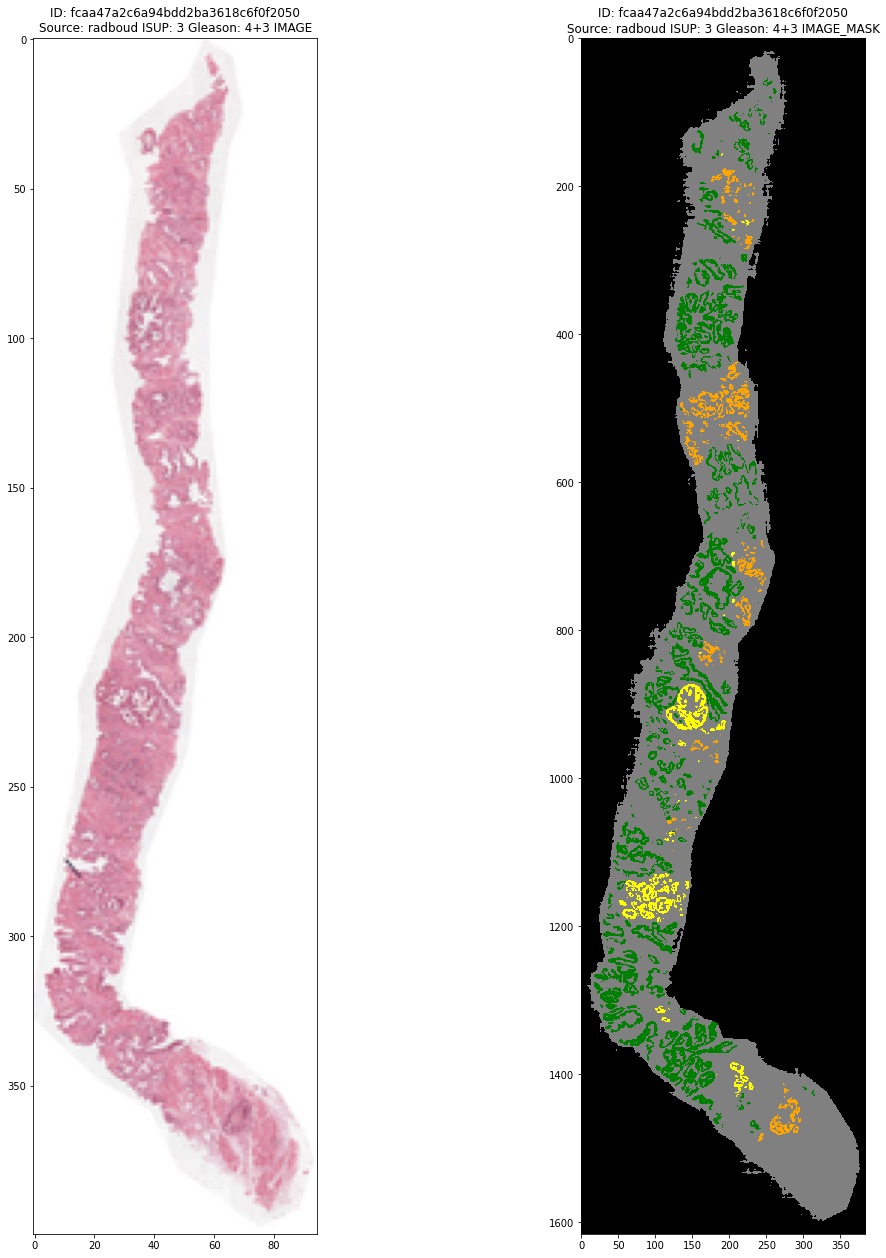

In [28]:
mask_img(333)

In [29]:
def differentiate_cancerous(i):
    mask =  openslide.OpenSlide(os.path.join(MASKS_DIR, f'{filenames[i]}.tiff'))
    mask_level = mask.read_region((0,0),mask.level_count - 1,mask.level_dimensions[-1]) #Selecting the level
    mask_data = np.asarray(mask_level)[:,:,0] #SELECTING R from RGB
    
    mask_background = np.where(mask_data == 0, 1, 0).astype(np.uint8) # SELECTING BG
    mask_benign = np.where(mask_data == 1, 1, 0).astype(np.uint8) #SELECTING BENIGN LABELS
    
    if train2.loc[filenames[i],'data_provider'] == 'karolinska':
        mask_cancerous = np.where(mask_data == 2, 1, 0).astype(np.uint8) #SELECTING CANCEROUS LABELS
    elif train2.loc[filenames[i],'data_provider'] == 'radboud':
        mask_cancerous = np.where(mask_data == 3, 1, 0).astype(np.uint8) #SELECTING CANCEROUS LABELS (faire varier le premier chiffre a un impact significatif : ?)
      # mask_cancerous = np.where(mask_data == 2, 1, 0).astype(np.uint8) #SELECTING NON-CANCEROUS LABELS
      # mask_cancerous = np.where(mask_data == 5, 1, 0).astype(np.uint8) #SELECTING NON-CANCEROUS LABELS

    fig, ax = plt.subplots(1, 3, figsize=(18, 12))

    ax[0].imshow(mask_background.astype(float), cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[0].set_title('background, data_provider:'+train2.loc[filenames[i]]["data_provider"]);
    ax[1].imshow(mask_benign.astype(float), cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title('benign');
    ax[2].imshow(mask_cancerous.astype(float), cmap=plt.cm.gray)
    ax[2].axis('off')
    ax[2].set_title('cancerous')
        
    # return mask_background,mask_benign,mask_cancerous

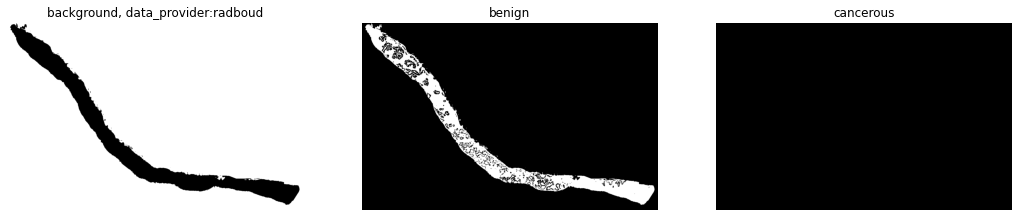

In [30]:
differentiate_cancerous(1)

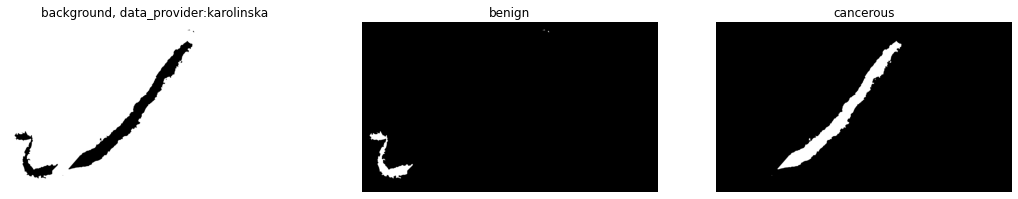

In [31]:
differentiate_cancerous(2)

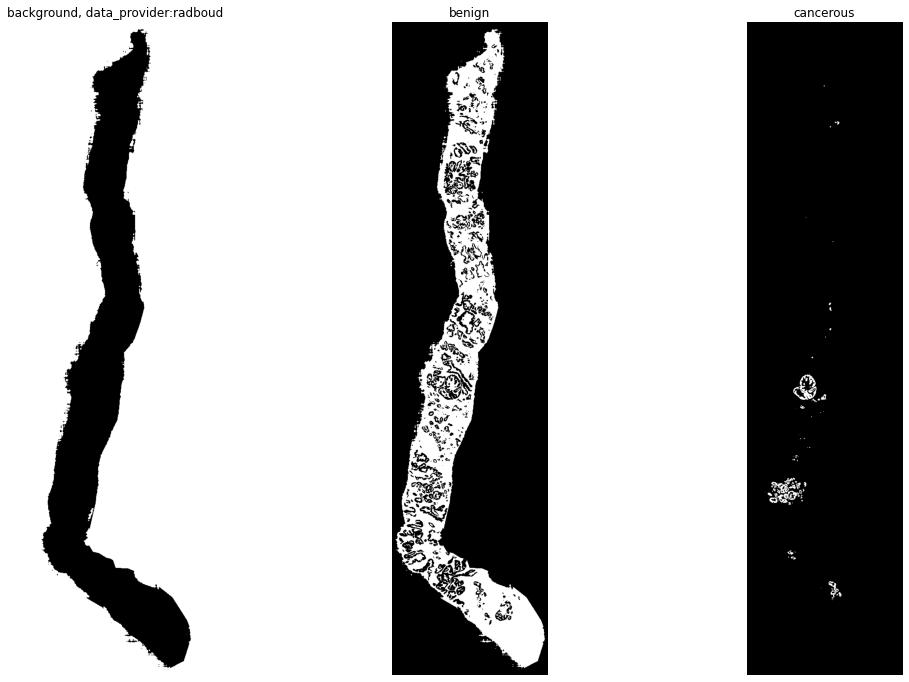

In [32]:
differentiate_cancerous(333)

In [33]:
def overlay_mask_on_slide(i, center='radboud', alpha=0.8, max_size=(800, 800)):
    """Show a mask overlayed on a slide."""
    f, ax = plt.subplots(1, 1, figsize=(18,22))
    
    slide = openslide.OpenSlide(os.path.join(TRAIN_DIR, f'{filenames[i]}.tiff'))
    mask =  openslide.OpenSlide(os.path.join(MASKS_DIR, f'{filenames[i]}.tiff'))
    slide_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
    mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
    mask_data = mask_data.split()[0]
    
    # Create alpha mask
    alpha_int = int(round(255*alpha))
    if center == 'radboud':
        alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
    elif center == 'karolinska':
        alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)

    alpha_content = PIL.Image.fromarray(alpha_content)
    preview_palette = np.zeros(shape=768, dtype=int)

    if center == 'radboud':
        # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
        preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
    elif center == 'karolinska':
        # Mapping: {0: background, 1: benign, 2: cancer}
        preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)

    mask_data.putpalette(data=preview_palette.tolist())
    mask_rgb = mask_data.convert(mode='RGB')
    overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
    overlayed_image.thumbnail(size=max_size, resample=0)

    
    ax.imshow(overlayed_image) 
    slide.close()
    mask.close()       
    ax.axis('off')
    
    data_provider = train2.loc[filenames[i], 'data_provider']
    isup_grade = train2.loc[filenames[i], 'isup_grade']
    gleason_score = train2.loc[filenames[i], 'gleason_score']
    ax.set_title(f"ID: {filenames[i]}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

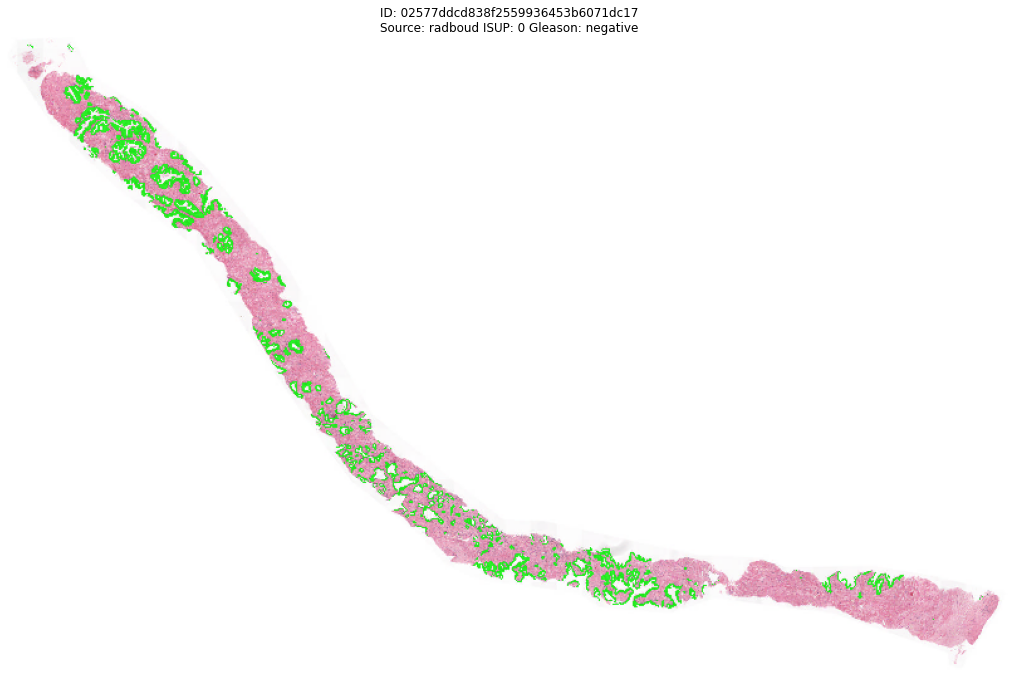

In [34]:
overlay_mask_on_slide(1)

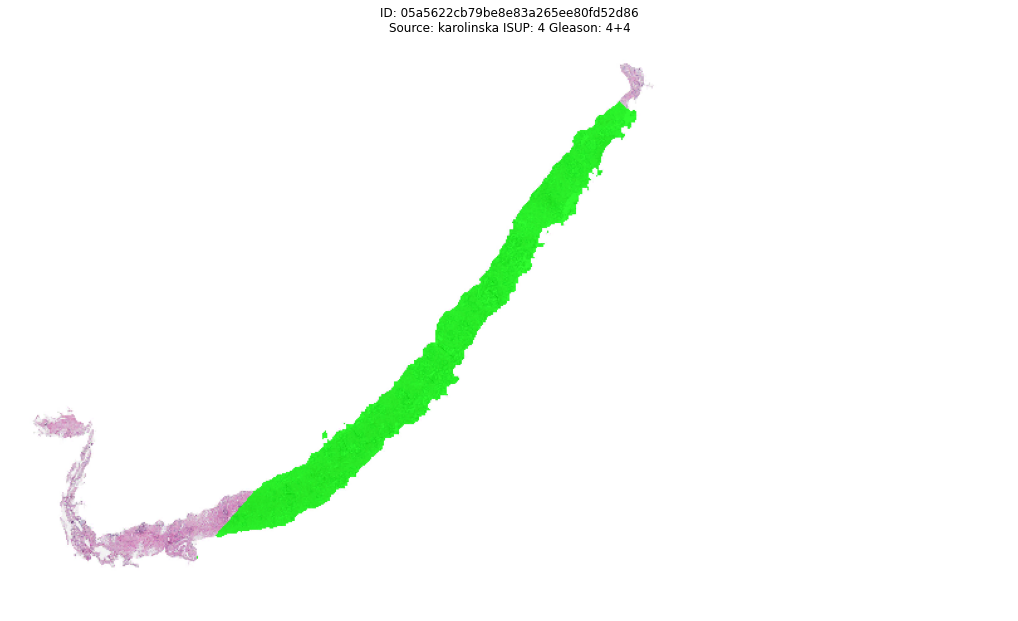

In [35]:
overlay_mask_on_slide(2)

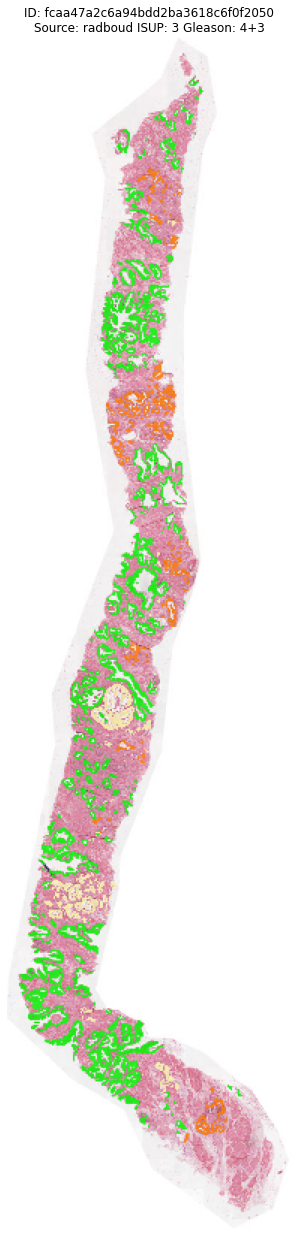

In [36]:
overlay_mask_on_slide(333)

In [41]:
# dims, spacings, level_counts = [], [], []
# down_levels, level_dims = [], []

# example = openslide.OpenSlide(os.path.join(TRAIN_DIR, filenames[0]))
# # example.get_thumbnail((1024, 1024))

# spacing = 1 / (float(example.properties['tiff.XResolution']) / 10000)
# dims.append(example.dimensions)
# spacings.append(spacing)
# level_counts.append(example.level_count)
# down_levels.append(example.level_downsamples)
# level_dims.append(example.level_dimensions)
# example.close()


In [42]:
# dims, spacings, level_counts = [], [], []
# down_levels, level_dims = [], []

# for i in train.index:
#     slide = openslide.OpenSlide(os.path.join(TRAIN_DIR, filenames[i]))
#     spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
#     dims.append(slide.dimensions)
#     spacings.append(spacing)
#     level_counts.append(slide.level_count)
#     down_levels.append(slide.level_downsamples)
#     level_dims.append(slide.level_dimensions)
#     slide.close()
#     del slide

# train['width']  = [i[0] for i in dims]
# train['height'] = [i[1] for i in dims]

In [ ]:
# plt.figure()
# p1=sns.kdeplot(train['width'], shade=True, color="b").set_title('KDE of Width and Height of images')
# p2=sns.kdeplot(train['height'], shade=True, color="r")
# plt.legend(labels=['width','height'])

# Deep Learning Model

In [ ]:
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# # determine if we will be pinning memory during data loading
# PIN_MEMORY = True if DEVICE == "cuda" else False

In [ ]:



def get_tiles(img, tile_size_in, n_tiles, tile_size_out):
    # find by how much we must pad the image so that the image dims are multiples of tile_size_in
    h, w, c = img.shape
    pad_h = (tile_size_in - h % tile_size_in) % tile_size_in
    pad_w = (tile_size_in - w % tile_size_in) % tile_size_in
    # pad the image with constant values (255)
    img = np.pad(img, [[pad_h//2, pad_h - pad_h//2], [pad_w//2, pad_w - pad_w//2], [0, 0]],
                 constant_values=0)
    # reshape the image and swap the order of the dims
    img = img.reshape(img.shape[0]//tile_size_in, tile_size_in, img.shape[1]//tile_size_in, tile_size_in, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size_in, tile_size_in, 3)
    # if the image has less tiles than n_tiles we pad
    if len(img) < n_tiles:
        img = np.pad(img,[[0, n_tiles - len(img)], [0, 0], [0, 0], [0, 0]], constant_values=0)   
    # select the tiles with the most tissue
    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[-n_tiles:]
    img = img[idxs]
    # store the tiles
    tiles = []
    for i in range(len(img)):
        tiles.append({'img':cv2.resize(img[i], (tile_size_out, tile_size_out)), 'idx':i})
    return tiles


def add_column_tiles(df, path_imgs):
    all_tiles = {}
    for i in progressbar(range(df.shape[0])):
        row = df.iloc[i]
        img_id = row.image_id    
        tiff_file = os.path.join(path_imgs, f"{img_id}.tiff")
        img = skimage.io.MultiImage(tiff_file)[-1]
        img[img.mean(axis=-1)>=235] = 0
        all_tiles[i] = get_tiles(img, int(np.sqrt((img!=0).sum())/14), 100, 100)
    df["tiles"] = list(all_tiles.values())


In [ ]:
# df_train = pd.read_csv("train.csv").drop([31, 57, 84, 137, 162, 245, \
#                                           246, 267, 284, 316], axis=0).reset_index(drop=True) # These images are too big and crash the colab kernel
# image_folder = "./train/train"

import imagecodecs

add_column_tiles(train, TRAIN_DIR)

  0% (2 of 340) |                        | Elapsed Time: 0:00:32 ETA:   1:15:43

OSError: ignored